# Deep learning thực nghiệm 

## Thí nghiệm 3: Chuẩn hóa layer input (batchNormalization)

### BS. Lê Ngọc Khả Nhi

## Giới thiệu

Đây là bài thứ 3 trong series Deep learning thực nghiệm, tại group Biomedical datascience initiatives. Mục tiêu của loạt bài này hướng đến việc tự học Deep learning thông qua những thí nghiệm trên dữ liệu mô phỏng, từ đó người học tự rút ra được kinh nghiệm để áp dụng vào thực tiễn. 

## Thí nghiệm thứ 3 : khảo sát hiệu quả của hàm BatchNormalisation

Trong bài hôm nay, ta sẽ làm thí nghiệm để khảo sát tác dụng của việc chuẩn hóa đầu vào của một layer trong mạng Deep neuralnet bằng hàm BatchNormalisation. 

Như chúng ta đã biết, quy trình huấn luyện một mạng neuron sâu nhắm đến việc cập nhật những giá trị weights tại mỗi layer, cho đến khi đạt hiệu năng hoạt động tối ưu. Tuy nhiên, sự thay đổi bất định theo từng batch dữ liệu và tại đầu vào mỗi layer khiến việc đi tìm trạng thái tối ưu của mô hình cũng giống như hành trình vô định, nhằm truy đuổi một mục tiêu di động. Do đó, ta hy vọng rằng khi dùng hàm Batch normalisation, ta có thể chủ động kiểm soát tính ổn định của layer input tại mỗi batch, từ đó rút ngắn hành trình huấn luyện và có nhiều cơ hội đạt mục tiêu mà ta tìm kiếm.

## Mục tiêu và phương pháp 

Cho thí nghiệm này, Nhi sẽ tạo ra một dữ liệu mô phỏng (n=1000), giả lập cho một bài toán nhị phân (binary classification) sử dụng 2 features. Một mô hình Multilayer Perceptron với 1 hidden_layer 64 neurons sẽ được dựng trong 2 điều kiện: Có và không có hàm BatchNormalisation, đặt tại vị trí giữa hidden layer (sau hàm activation Relu) và output layer. Hiệu năng của 2 mô hình được so sánh, dựa vào tiêu chí Accuracy và F1_score trên 30 lượt tái chọn mẫu.

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

import numpy as np
from numpy import where
from numpy import argmax

from keras.layers import Dense
from keras.models import Sequential
from keras.layers import Activation
from keras.layers import BatchNormalization # Target !
from keras.optimizers import SGD
from keras.callbacks import EarlyStopping

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.style.use('seaborn-whitegrid')
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

from sklearn.datasets.samples_generator import *
from sklearn.metrics import *

Nhi viết 1 hàm để tạo dữ liệu mô phỏng, sử dụng hàm make_moons của scikit-learn để tạo ra 1 bài toán nhị phân 2 features với ranh giới giữa 2 cụm label tương đối phức tạp. Dữ liệu này sau đó được cắt thành 2 phần đều nhau là trainset, testset. Lưu ý: argument plot_sample=True/False cho phép bật tắt chức năng vẽ đồ thị.

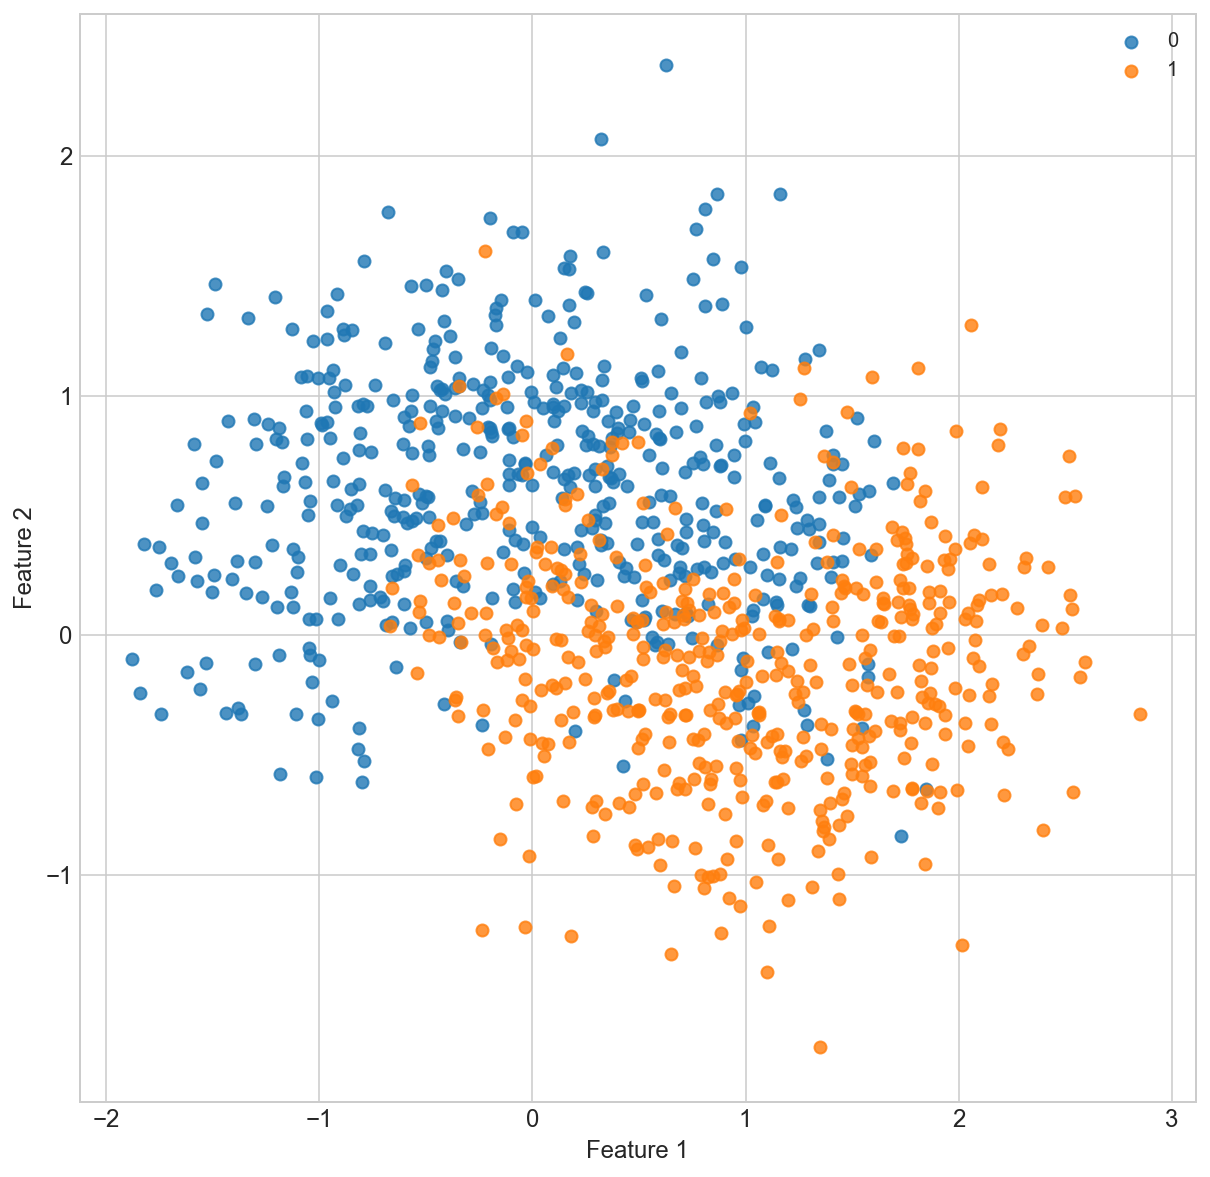

In [67]:
def sim_binary_moon(size=1000,
                   noise=0.4,
                   train_ratio=0.5,
                   plot_sample=True):
    X, y = make_moons(n_samples=size,
                  shuffle = True,
                  noise = noise)
    if plot_sample:
        plt.figure(figsize=(10,10))
        for i in range(2):
            samples_id = where(y == i)
            plt.scatter(X[samples_id, 0], 
                   X[samples_id, 1], 
                   label=str(i),
                  alpha=0.8)
        plt.xlabel('Feature 1')
        plt.ylabel('Feature 2')
        plt.legend()
        plt.show()
    n_train = int(size*train_ratio)
    trainX, testX = X[:n_train, :], X[n_train:, :]
    trainy, testy = y[:n_train], y[n_train:]
    return trainX, trainy, testX, testy

trainX, trainy, testX, testy = sim_binary_moon(plot_sample=True)

Tiếp theo, Nhi chuẩn bị hàm batch_norm_experiment để thực hiện thí nghiệm. Hàm này có 2 argument: batchnorm và graph. Ở điều kiện batchnorm = True, ta sẽ dựng mô hình MLP có chuẩn hóa layer bằng batchnormalisation, trái lại khi batchnorm = False, tính năng batchnormalisation sẽ không được ứng dụng. 

Mô hình sẽ được huấn luyện bằng chế độ SGD, learning rate  = 0.01; và có áp dụng early stopping.

Argument graph cho phép bật tắt tính năng vẽ đồ thị khảo sát diễn tiến hàm loss và accuracy trên testset.

In [69]:
def history_plot(history = None):
    plt.figure(figsize=(10,5))
    plt.plot(hist.history['loss'],'b-',label='train')
    plt.plot(hist.history['val_loss'],'r--', label='test')
    plt.title('Model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend()
    plt.show()
    
    plt.figure(figsize=(10,5))
    plt.plot(hist.history['acc'],'b-', label='train')
    plt.plot(hist.history['val_acc'],'r--', label='test')
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('epoch')
    plt.legend()
    plt.show()

In [149]:
def batch_norm_experiment(batchnorm=True, graph=False):
    early_stop = EarlyStopping(monitor='val_loss', 
                           patience=10, 
                           verbose=0)
    model = Sequential()
    model.add(Dense(units=64,
                    input_dim=2,
                    activation='relu', 
                    kernel_initializer='he_uniform'))
    if batchnorm: 
        model.add(BatchNormalization())
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', 
              optimizer=SGD(lr=0.01, momentum=0.9),
              metrics=['accuracy'])
    hist = model.fit(trainX, trainy,
                    validation_data=(testX, testy), 
                    epochs=300, 
                    verbose=0,
                    batch_size=64,
                    callbacks=[early_stop])
    _, train_acc = model.evaluate(trainX, trainy, verbose=0)
    _, test_acc = model.evaluate(testX, testy, verbose=0)
    if graph:
        history_plot(history = hist)
    print('Train ACC: %.5f, Test ACC: %.5f' % (train_acc, test_acc))
    return model, hist

## A) Khi không áp dụng Batchnorm

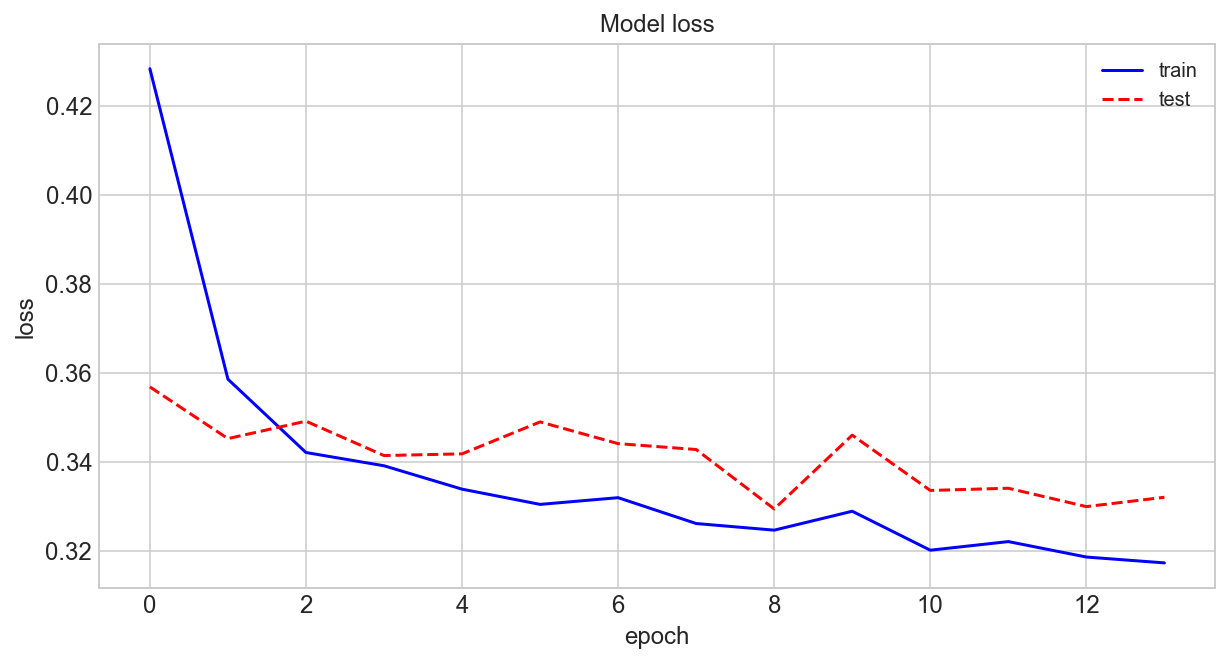

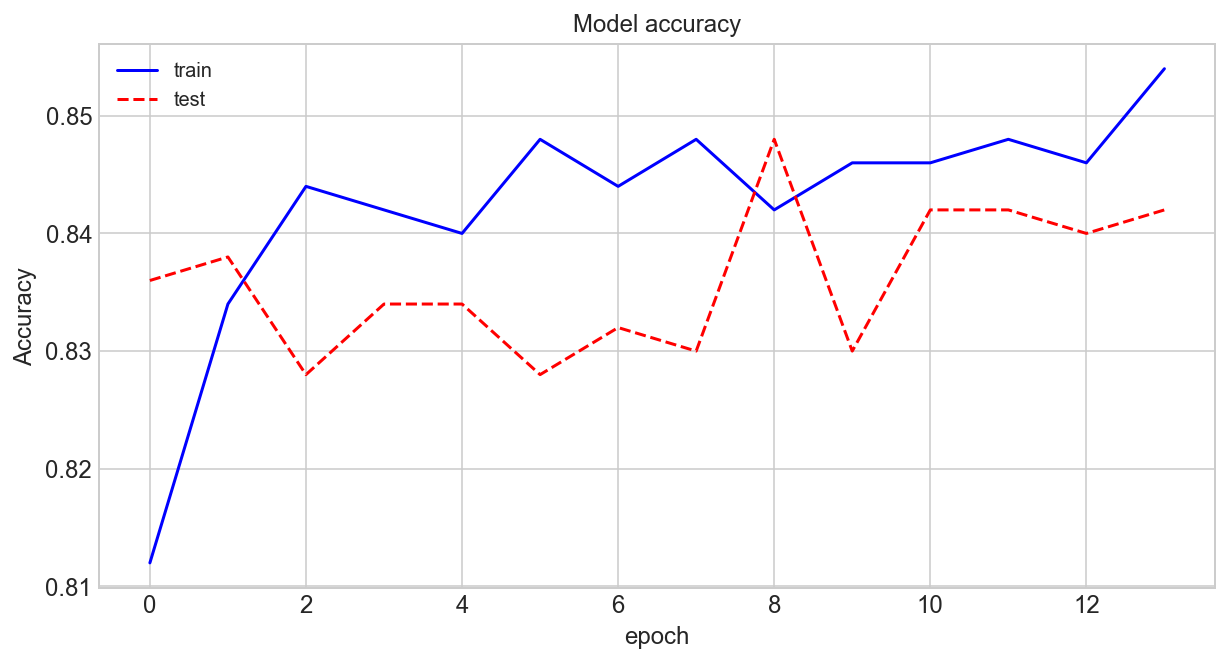

Train ACC: 0.83000, Test ACC: 0.83800


In [155]:
model1, hist1 = batch_norm_experiment(batchnorm=False,graph=True)

## B) Khi có áp dụng Batchnorm

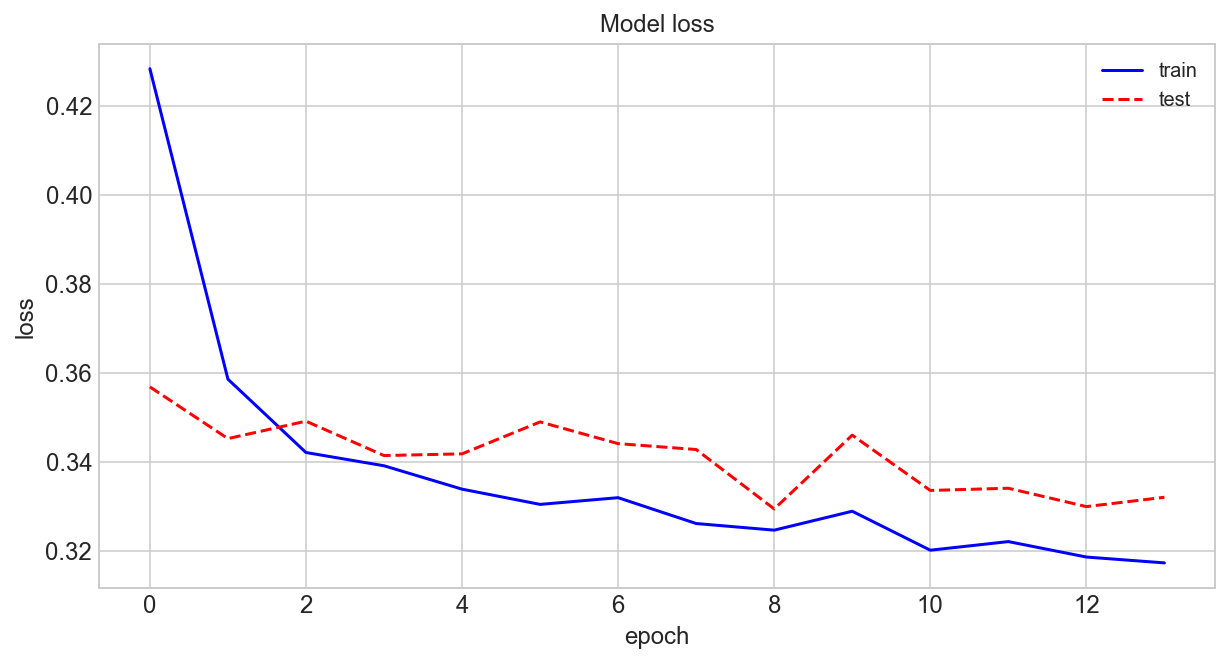

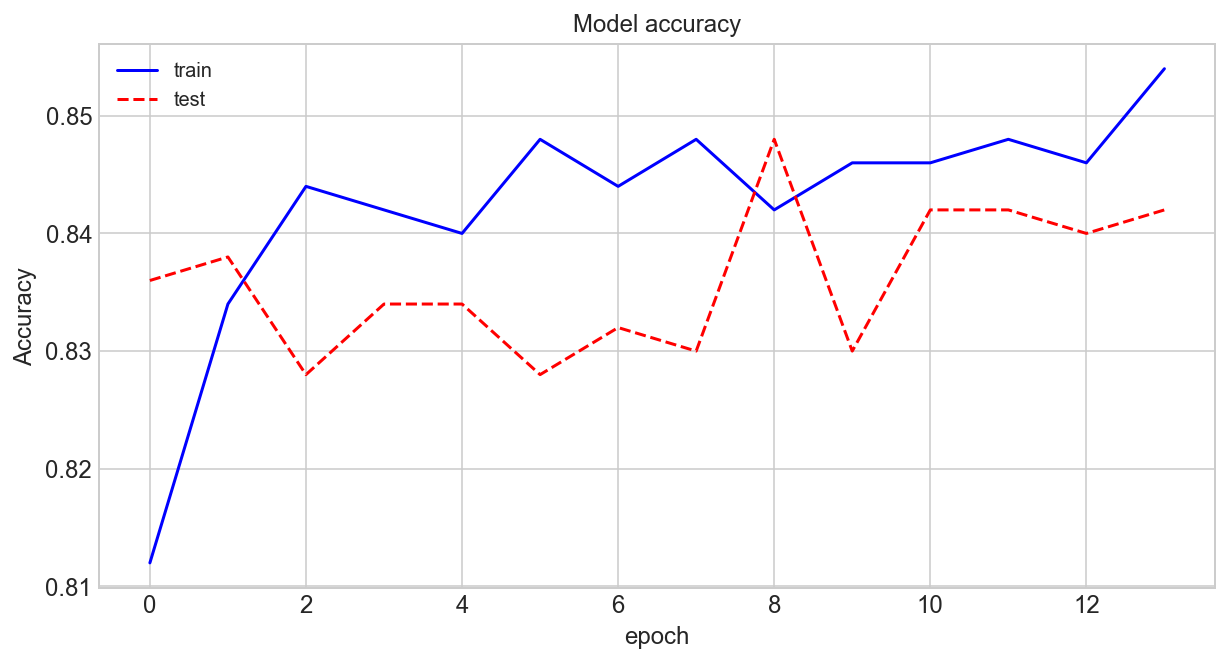

Train ACC: 0.85200, Test ACC: 0.84400


In [156]:
model2, hist2 = batch_norm_experiment(batchnorm=True, graph=True)

Trên 1 mẫu, không thấy khác biệt rõ rệt về diễn tiến của hàm loss và accuracy giữa 2 phiên bản mô hình; tuy nhiên có vẻ như mô hình có sử dụng Batch normalisation có Accuracy cao hơn 1 chút so với mô hình không chuẩn hóa input layer.

Để kiểm tra giả thuyết này, chúng ta lặp lại thí nghiệm trên 30 bài toán khác nhau, như dưới đây:

In [130]:
resample=30
df = pd.DataFrame()

print('-----------------------')
for resample_idx in range(resample):
    print('Sample N°=%d:' % resample_idx)
    print('-----------------------')
    
    trainX, trainy, testX, testy = sim_binary_moon(plot_sample=False)
    model1,hist1=batch_norm_experiment(batchnorm=False,graph=False)
    _, test_acc1 = model1.evaluate(testX, testy, verbose=0)
    y_pred1 = model1.predict_classes(testX)
    f1=f1_score(testy,y_pred1)
    df = df.append({'resample': str(resample_idx),
                    'batch_norm': str('FALSE'),
                    'F1_score': f1,
                    'Accuracy': test_acc1},ignore_index=True)
    print('-----------------------')
    
    model2,hist2=batch_norm_experiment(batchnorm=True,graph=False)
    y_pred2 = model2.predict_classes(testX)
    f2=f1_score(testy,y_pred2)
    _, test_acc2 = model2.evaluate(testX, testy, verbose=0)
    df = df.append({'resample': str(resample_idx),
                    'batch_norm': str('TRUE'),
                    'F1_score': f2,
                    'Accuracy': test_acc2},ignore_index=True)

-----------------------
Sample N°=0:
-----------------------
Train ACC: 0.88600, Test ACC: 0.86600
-----------------------
Train ACC: 0.89000, Test ACC: 0.87000
Sample N°=1:
-----------------------
Train ACC: 0.87200, Test ACC: 0.83600
-----------------------
Train ACC: 0.88400, Test ACC: 0.86200
Sample N°=2:
-----------------------
Train ACC: 0.87000, Test ACC: 0.83600
-----------------------
Train ACC: 0.87200, Test ACC: 0.85000
Sample N°=3:
-----------------------
Train ACC: 0.85200, Test ACC: 0.88400
-----------------------
Train ACC: 0.83000, Test ACC: 0.84600
Sample N°=4:
-----------------------
Train ACC: 0.83200, Test ACC: 0.82200
-----------------------
Train ACC: 0.85200, Test ACC: 0.83000
Sample N°=5:
-----------------------
Train ACC: 0.84800, Test ACC: 0.85400
-----------------------
Train ACC: 0.84800, Test ACC: 0.86000
Sample N°=6:
-----------------------
Train ACC: 0.87800, Test ACC: 0.88000
-----------------------
Train ACC: 0.87400, Test ACC: 0.88000
Sample N°=7:
----

Ta so sánh Accuracy và F1 score giữa 30 mô hình Có dùng Batchnorm và 30 mô hình không dùng batchnorm. Biểu đồ cho thấy khi có dùng batchnorm, mô hình có Accuracy và F1 score cao hơn 1 cách có ý nghĩa so với khi không dùng batchnorm. 

Text(0,0.5,'Accuracy')

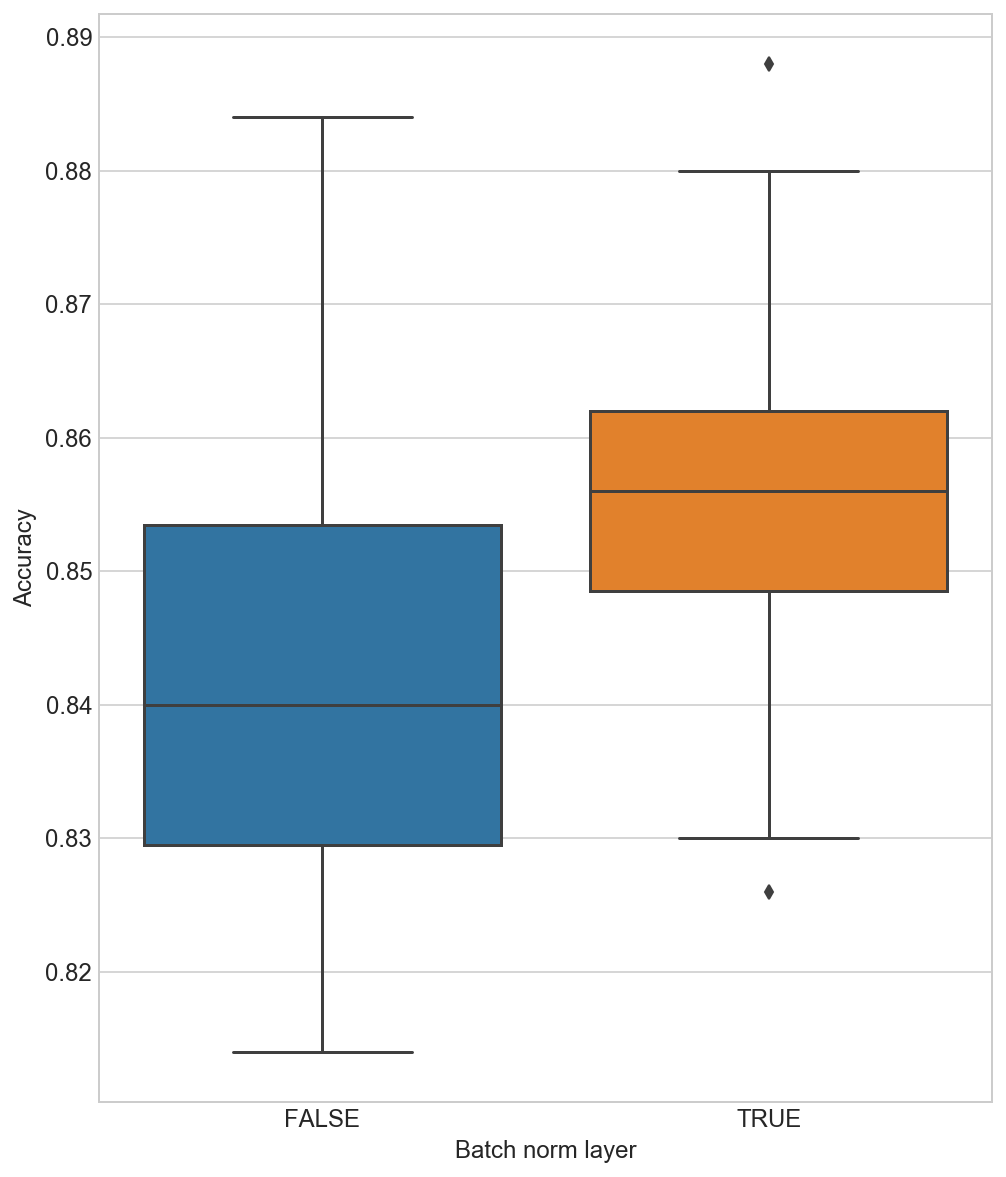

In [134]:
plt.figure(figsize=(8,10))
sns.boxplot(x='batch_norm',y='Accuracy',data=df)
plt.xlabel('Batch norm layer')
plt.ylabel('Accuracy')

Text(0,0.5,'F1_score')

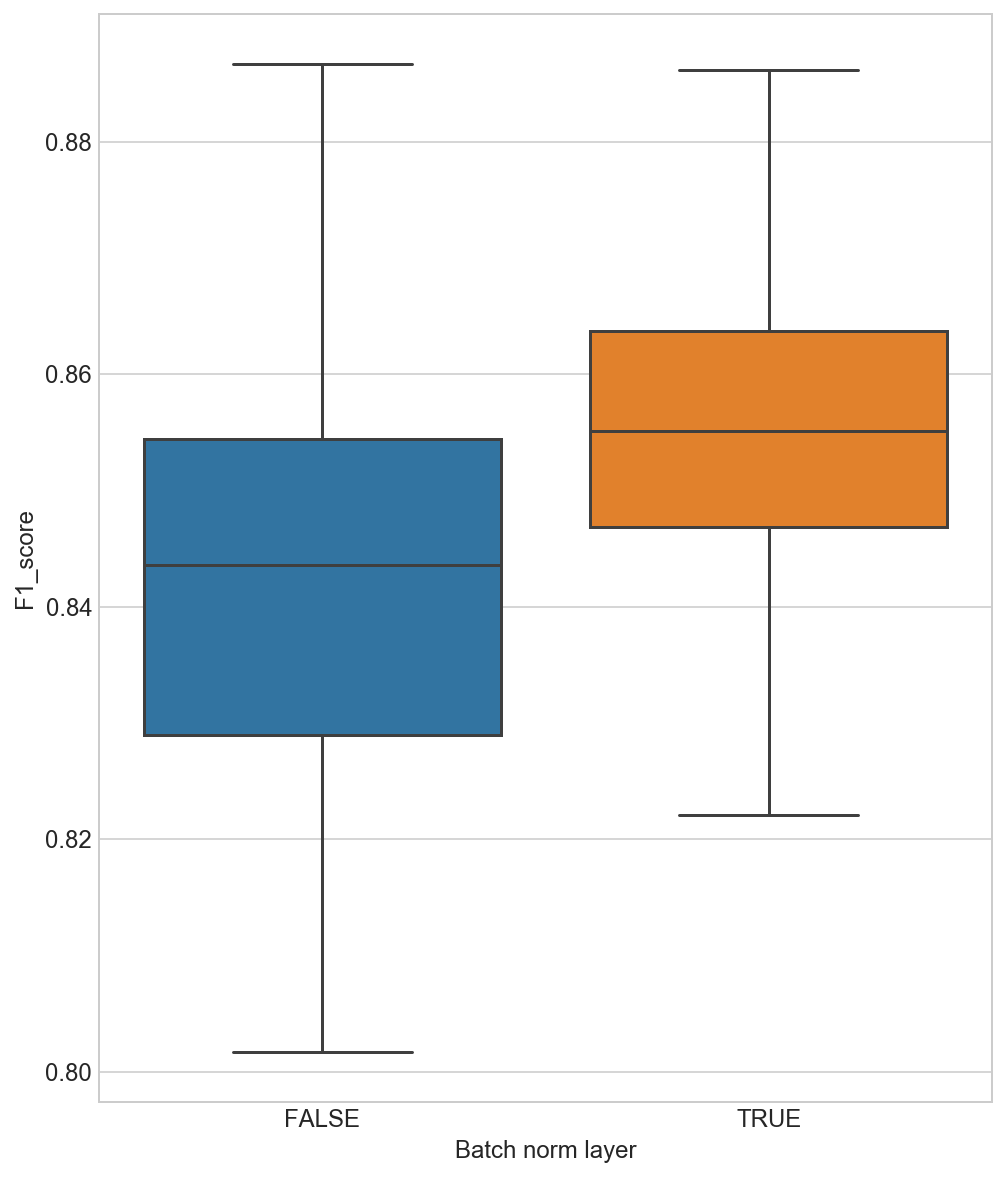

In [133]:
plt.figure(figsize=(8,10))
sns.boxplot(x='batch_norm',y='F1_score',data=df)
plt.xlabel('Batch norm layer')
plt.ylabel('F1_score')

In [144]:
from scipy.stats import ttest_ind as t_test

In [145]:
t_test(*df.groupby('batch_norm')['Accuracy'].apply(lambda x:list(x)))

Ttest_indResult(statistic=-2.892561584326601, pvalue=0.005372749917501347)

In [146]:
t_test(*df.groupby('batch_norm')['F1_score'].apply(lambda x:list(x)))

Ttest_indResult(statistic=-2.8785733127289803, pvalue=0.005585177180059395)

## Kết luận

Qua thí nghiệm đơn giản này, có thể kết luận rằng việc áp dụng Batch normalisation ngay trước 1 layer hoặc output layer có tác dụng tích cực đối với hiệu năng của mô hình. 

Hẹn gặp lại các bạn vào lần tới.